# Predicting self-esteem using whole-brain DTI patterns
*Rob Chavez - May 15th, 2018*

I have had a long standing interest in using whole-brain 'decoding' methods on diffusion tensor imaging (DTI) data to predict individual differences in personality traits. Today, I have decided to finally try this out using data I had previously collected as a graduate student. The code below is a reanalysis of [Chavez & Heatherton (2015)](https://academic.oup.com/scan/article/10/3/364/1653348) data. Here, we will look at the performance of these predictive models using two different inputs:
* FA data smoothed at 2mm FWHM and masked at a group-mean FA value > .3 
* Skeletonize FA data from TBSS

The smoothed data will cover more white matter, however the smoothing and thresholding are arbitrary and misalignments are common. On the other hand, the TBSS data overcomes some of these alligment issues but throws out a lot of potentially informative white matter. I will look to see how these two approaches might look different. For simplicity, I am first going to test these predictions in a holdout sample using half the data. Later, I am going to use the full sample in a leave-one-out cross-validation approach. 

This analysis is done using the [nltools](https://github.com/ljchang/nltools) toolbox writen by Luke Chang and his lab and is borrows heavily from this [decoding example](https://github.com/Summer-MIND/mind_2017/blob/master/Tutorials/Decoding/Chang_Decoding.ipynb) that Luke Chang presented at the 2017 Dartmouth MIND summer school workshop.

**Note:** Although I am providing the code here, unfortunately this example cannot be completely reproducible because I do not approval to share the data. Sorry about that.



In [1]:
%matplotlib inline
from nltools.data import Brain_Data

from nilearn import plotting, image, input_data, datasets
import numpy as np
import pandas as pd
import os
import nltools as nlt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr



/Users/rchavez/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load data
Here we will load the behavioral data and both smoothed and skeletonized 4D nifti files.

### Behavioral data

In [2]:
# load behavior and assign subject ID
os.chdir("/Users/rchavez/Desktop/dartmouth/stats/")
behav = pd.read_csv('../FA/behavioral_data.csv')
behav['SubjectID'] = np.arange(1,49)

# create split-half data partition
behav['Holdout'] = ['train','test'] * 24 


### DTI data

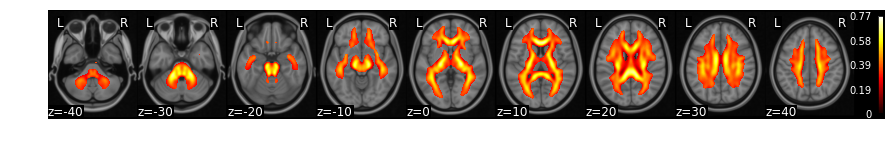

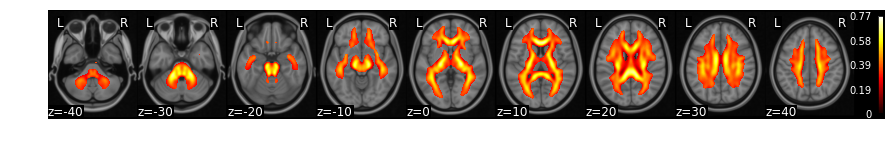

In [3]:
# smoothed
fa_smooth = Brain_Data('../FA/smoothed_2mm_n48.nii.gz', mask = '../FA/mean_smooth_thr3_mask.nii.gz', X = behav)
fa_smooth.mean().plot()

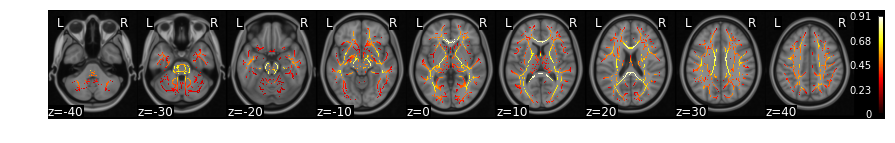

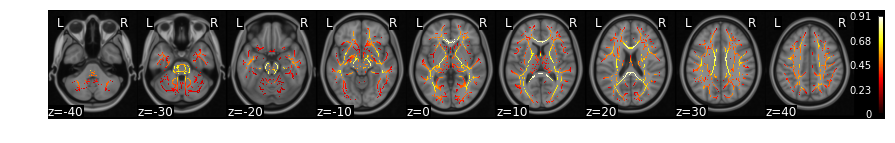

In [4]:
# skeletonized
fa_skeleton = Brain_Data('all_FA_skeletonised.nii.gz', mask = 'mean_FA_skeleton_mask.nii.gz',  X = behav)
fa_skeleton.mean().plot()

# Modeling with holdout sample
The code below will fit a support vector regression model to each version of the FA data and test the model in the holdout sample.

### Smoothed 
Here we will split the sample, train the model, and plot the weight map.

overall Root Mean Squared Error: 0.10
overall Correlation: 1.00
Plotting unthresholded image


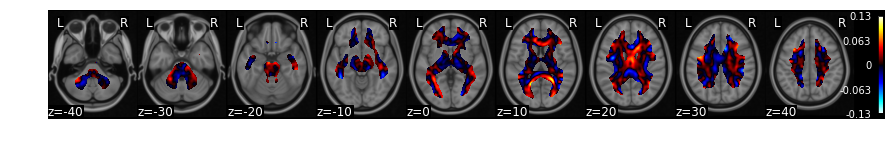

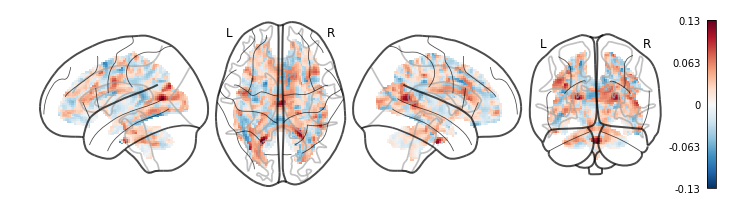

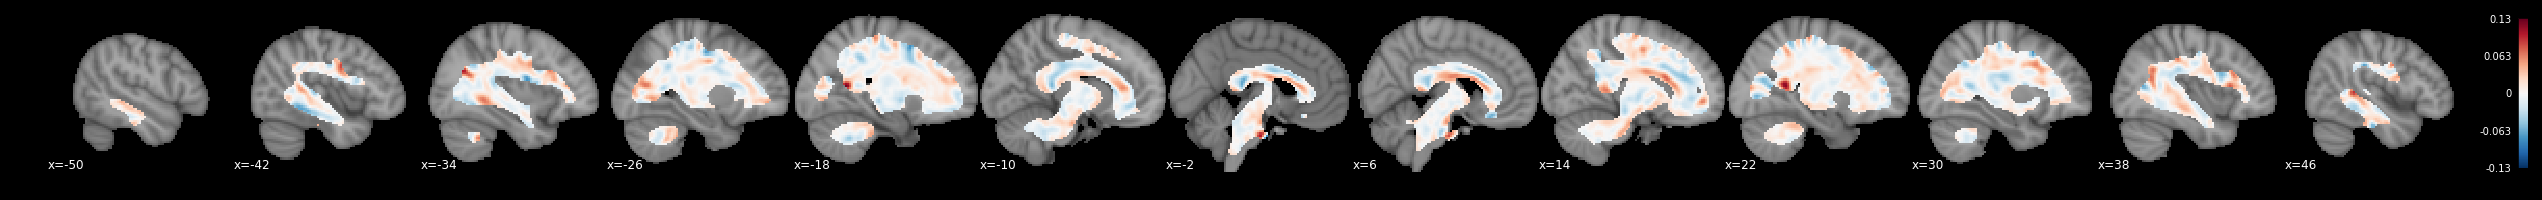

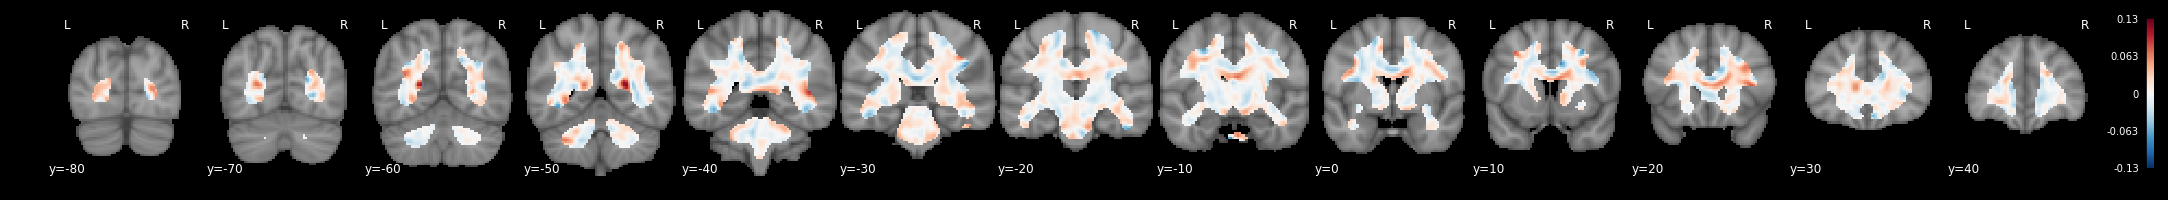

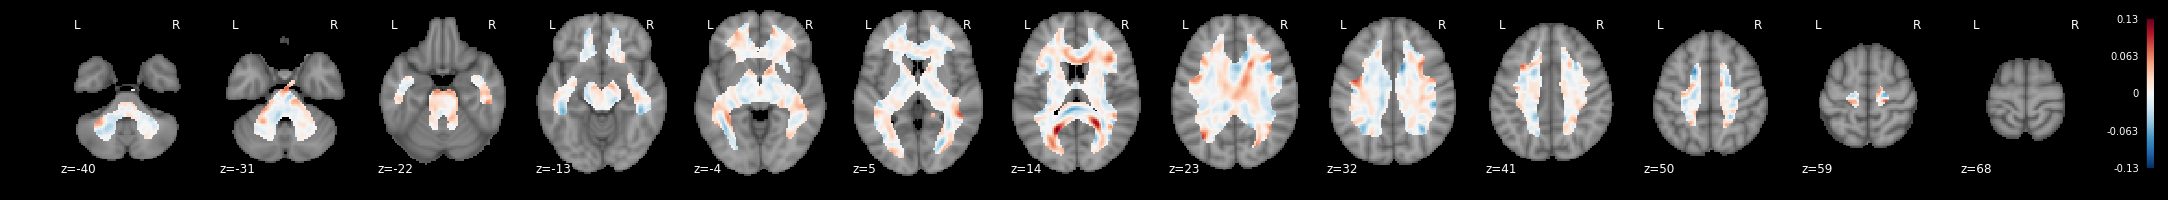

In [5]:
# split data one train/test
train = fa_smooth[fa_smooth.X['Holdout']=='train']
train.Y = train.X['Selfesteem']

test = fa_smooth[fa_smooth.X['Holdout']=='test']
test.Y = test.X['Selfesteem']

# fit model
stats_smoothed = train.predict(algorithm='svr',plot=True, **{'kernel':'linear'})

from nltools.plotting import plotBrain
plotBrain(stats_smoothed['weight_map'])

Now let's see how it does in the holdout sample.

Holdout: R = 0.315857908109, p = 0.132690900424, R2 = 0.0997662181147, RMSE =  18.614410925


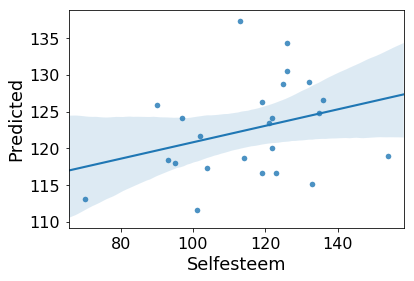

In [6]:
# apply predictions to holdout data
predicted_se_smooth = test.similarity(stats_smoothed['weight_map'],'dot_product') + stats_smoothed['intercept']

data_smooth = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_se_smooth,'Selfesteem':test.X['Selfesteem']})

# scatter plot of predicted values
with sns.plotting_context(context='paper',font_scale=2):
    sns.regplot(data=data_smooth,x='Selfesteem',y='Predicted')

# calculate fit metrics    
fit = pearsonr(data_smooth.Selfesteem, data_smooth.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_smooth.Selfesteem, data_smooth.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Skeletonized
Here, we will do the same proceedure on the skeletonized data. 

overall Root Mean Squared Error: 0.10
overall Correlation: 1.00
Plotting unthresholded image


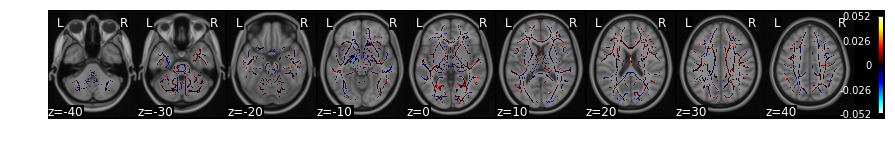

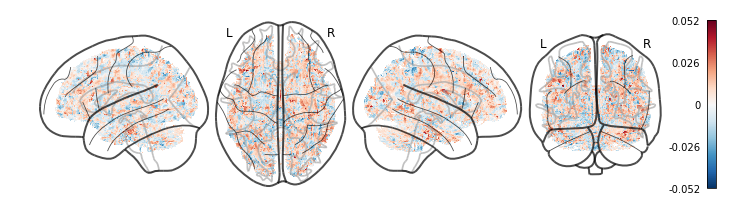

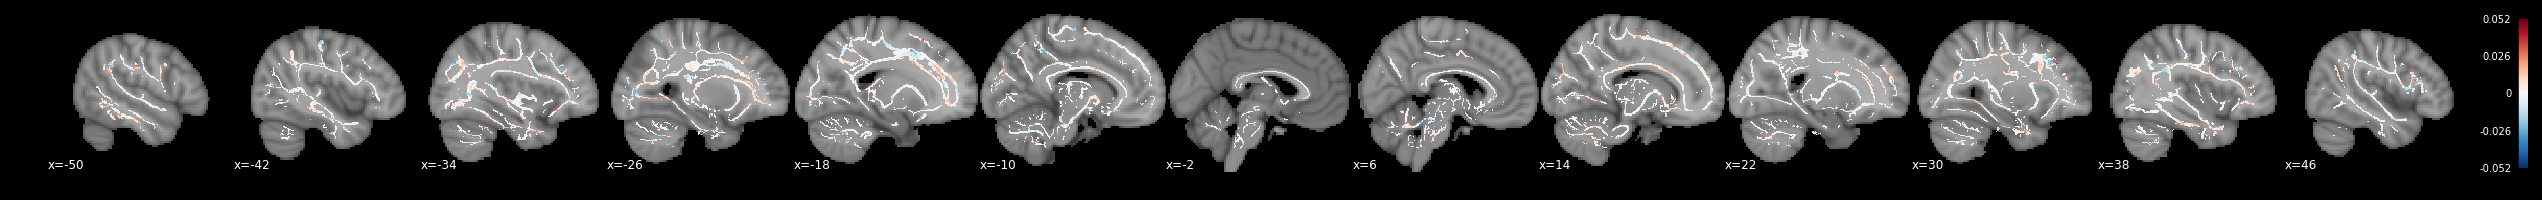

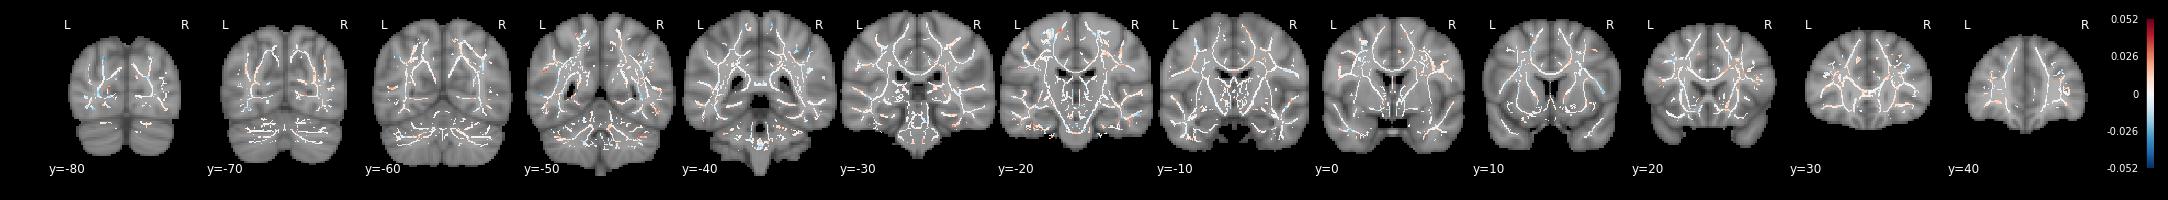

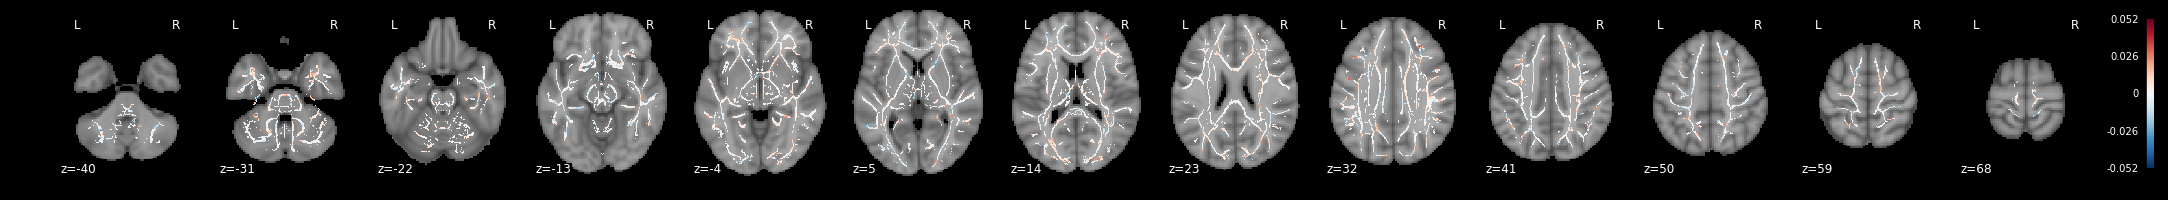

In [7]:
# split data one train/test
train = fa_skeleton[fa_skeleton.X['Holdout']=='train']
train.Y = train.X['Selfesteem']

test = fa_skeleton[fa_skeleton.X['Holdout']=='test']
test.Y = test.X['Selfesteem']

# fit model
stats_skeleton = train.predict(algorithm='svr',plot=True, **{'kernel':'linear'})

from nltools.plotting import plotBrain
plotBrain(stats_skeleton['weight_map'])

Holdout: R = 0.411300334657, p = 0.0458513061588, R2 = 0.169167965289, RMSE =  19.7594293395


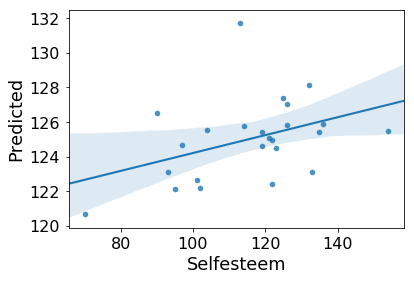

In [8]:
# apply predictions to holdout data
predicted_se_skeleton = test.similarity(stats_skeleton['weight_map'],'dot_product') + stats_skeleton['intercept']

data_skeleton = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_se_skeleton,'Selfesteem':test.X['Selfesteem']})

# scatter plot of predicted values
with sns.plotting_context(context='paper',font_scale=2):
    sns.regplot(data=data_skeleton,x='Selfesteem',y='Predicted')

# calculate fit metrics    
fit = pearsonr(data_skeleton.Selfesteem, data_skeleton.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_skeleton.Selfesteem, data_skeleton.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

# Modeling LOOCV

The data below are modeled using the whole data set with leave-one-out cross-validation. 

overall Root Mean Squared Error: 0.10
overall Correlation: 1.00
overall CV Root Mean Squared Error: 18.08
overall CV Correlation: 0.25


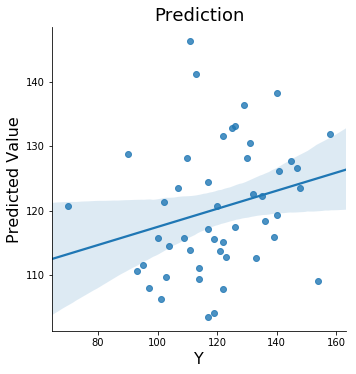

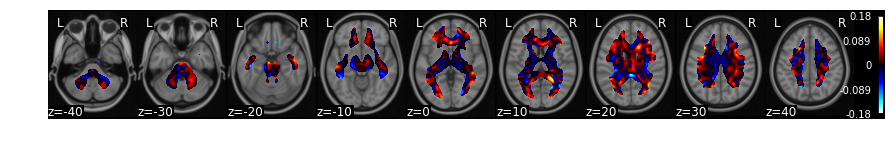

In [9]:
# No holdout, full cross validation
all_smooth = fa_smooth
all_smooth.Y = fa_smooth.X['Selfesteem']
subject_id = all_smooth.X['SubjectID']

# fit model
stats_skeleton_all = all_smooth.predict(algorithm='svr', cv_dict={'type': 'loso','subject_id':subject_id}, plot=True,  **{'kernel':'linear'})

overall Root Mean Squared Error: 0.10
overall Correlation: 1.00
overall CV Root Mean Squared Error: 17.86
overall CV Correlation: 0.10


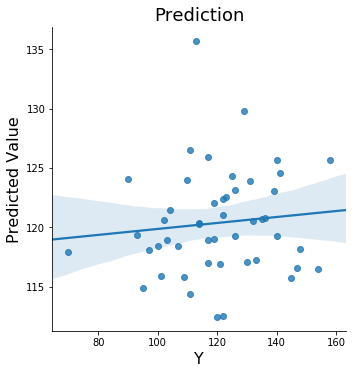

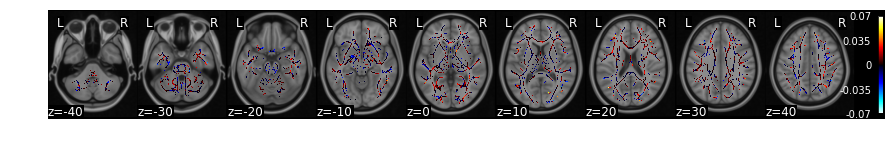

In [10]:
# No holdout, full cross validation
all_skeleton = fa_skeleton
all_skeleton.Y = fa_smooth.X['Selfesteem']
subject_id = all_skeleton.X['SubjectID']

# fit model
stats_skeleton_all = all_skeleton.predict(algorithm='svr', cv_dict={'type': 'loso','subject_id':subject_id}, plot=True, **{'kernel':'linear'})

# Conclusions

Here are some quick take-aways:

* weight maps show that distributed white matter areas are contributing to these predicitons
* smoothed data gives more visually interpretable weight maps 
* skeletonized FA out-performed smoothed in the holdout sample according to R²
* smoothed FA out-performed skeletonized in the LOOCV using according to R²
* RMSE was roughly comparable across all methods


There is some interesting stuff in here but it also brings up other quesitons that I need to think about a bit more. Obviously, this is only a very small subset of the possible permutations of models, smoothing, and cross-validation that can be done and this is a relatively small sample. However, I am encouraged by this and think it may be an intersting way of incorporating a ["biomarker"](https://www.nature.com/articles/nn.4478) predictive modeling approach into some of my dMRI work. 